<a href="https://colab.research.google.com/github/AITrading1995/AITrading1995/blob/main/Multi_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git mplfinance backtesting pandas_ta numpy==1.23.5

In [ ]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf
import math
import numpy as np
from backtesting import Backtest, Strategy
from tvDatafeed import TvDatafeed, Interval
import datetime as dt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [162]:
def download(symbol,exchange,tf,bar):
  tf_map = {
      '1m': Interval.in_1_minute,
      '5m': Interval.in_5_minute,
      '15m': Interval.in_15_minute,
      '30m': Interval.in_30_minute,
      '1h': Interval.in_1_hour,
      '2h': Interval.in_2_hour,
      '4h': Interval.in_4_hour,
      '1d': Interval.in_daily
  }
  tv = TvDatafeed()
  data = tv.get_hist(symbol=symbol,exchange=exchange,interval=tf_map[tf],n_bars=bar)
  if data is not None:
    data.drop(columns='symbol', inplace=True)
    data.rename({
        'open':'Open'
        ,'high':'High'
        ,'low':'Low'
        ,'close':'Close'
        ,'volume':'Volume'}, axis='columns', inplace=True)
  return data

In [163]:
symbol = 'XAUUSD'
exchange = 'OANDA'
tf = '1h'
bar = 10000
df = download(symbol,exchange,tf,bar)

In [164]:
multi_symbol = ['XAUUSD','USDJPY','AUDNZD','GBPEUR','USDCAD','AUDCAD','AUDJPY','CADJPY','USDTHB','XAGUSD','US30','CAC40']
multi_data= {}
for sym in multi_symbol:
  data=download(sym,'OANDA','1h',10000)
  multi_data[sym] = data

ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


In [165]:
multi_data_list =[]
for sym in multi_symbol:
  data=download(sym,'OANDA','1h',10000)
  multi_data_list.append(data)

ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


In [166]:
multi_data.keys()

dict_keys(['XAUUSD', 'USDJPY', 'AUDNZD', 'GBPEUR', 'USDCAD', 'AUDCAD', 'AUDJPY', 'CADJPY', 'USDTHB', 'XAGUSD', 'US30', 'CAC40'])

In [167]:
dfs = {symbol : df['Close'] for symbol , df in multi_data.items() if df is not None}
dfs = pd.DataFrame(dfs)

In [168]:
dfs.dropna(inplace=True)

In [169]:
returns = np.log(dfs / dfs.shift(1))
corr = returns.corr()

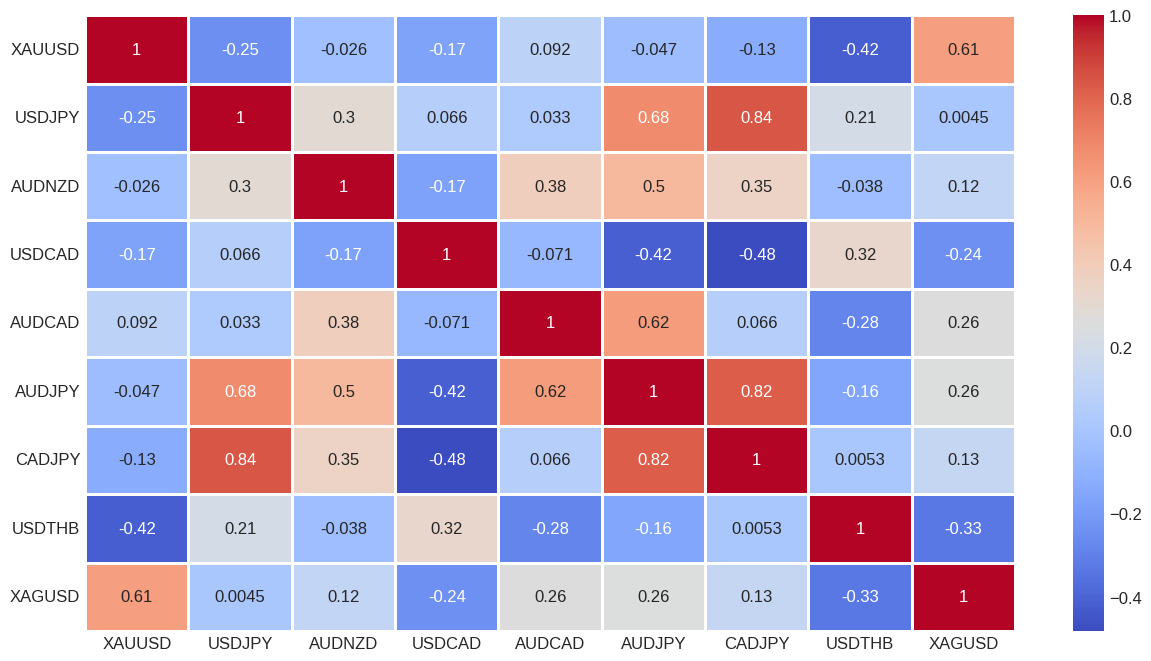

In [86]:
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, cmap='coolwarm',linewidths=1)
plt.show()

In [170]:
def parkinson_vol(high,low,length):
  high = np.asanyarray(high)
  low = np.asanyarray(low)
  n = high.shape[0]
  vol = np.full(n,np.nan)

  log_high_sqrt = np.log(high/low)**2
  for i in range(length,n):
    sum_sqrt = np.sum(log_high_sqrt[i-length:i])
    vol[i] = np.sqrt((1/(4*length*np.log(2)))*(2*sum_sqrt))
  return vol

In [171]:
def ema(data, period):
    if data is None or len(data) == 0:
        return np.array([])
    return pd.Series(data).ewm(span=period, adjust=False).mean().to_numpy()

def sma(data, period):
    if data is None or len(data) == 0:
        return np.array([])
    return pd.Series(data).rolling(window=period).mean().to_numpy()

def derivertive_1(df):
  return np.gradient(df)
def derivertive_2(df):
  return np.gradient(derivertive_1(df))

In [172]:
df['vol'] = parkinson_vol(df['High'],df['Low'],30)
df['ema_vol'] = sma(df['vol'],30)
df['ema'] = sma(df['Close'],50)
df['derivertive_1'] = derivertive_1(df['vol'])
df['derivertive_2'] = derivertive_2(df['vol'])

print(df.index[-1])

2025-05-26 02:00:00


#Logic
Close > ema
derivertive_1 > 0.000004
vol.shift(1) > vol_ema



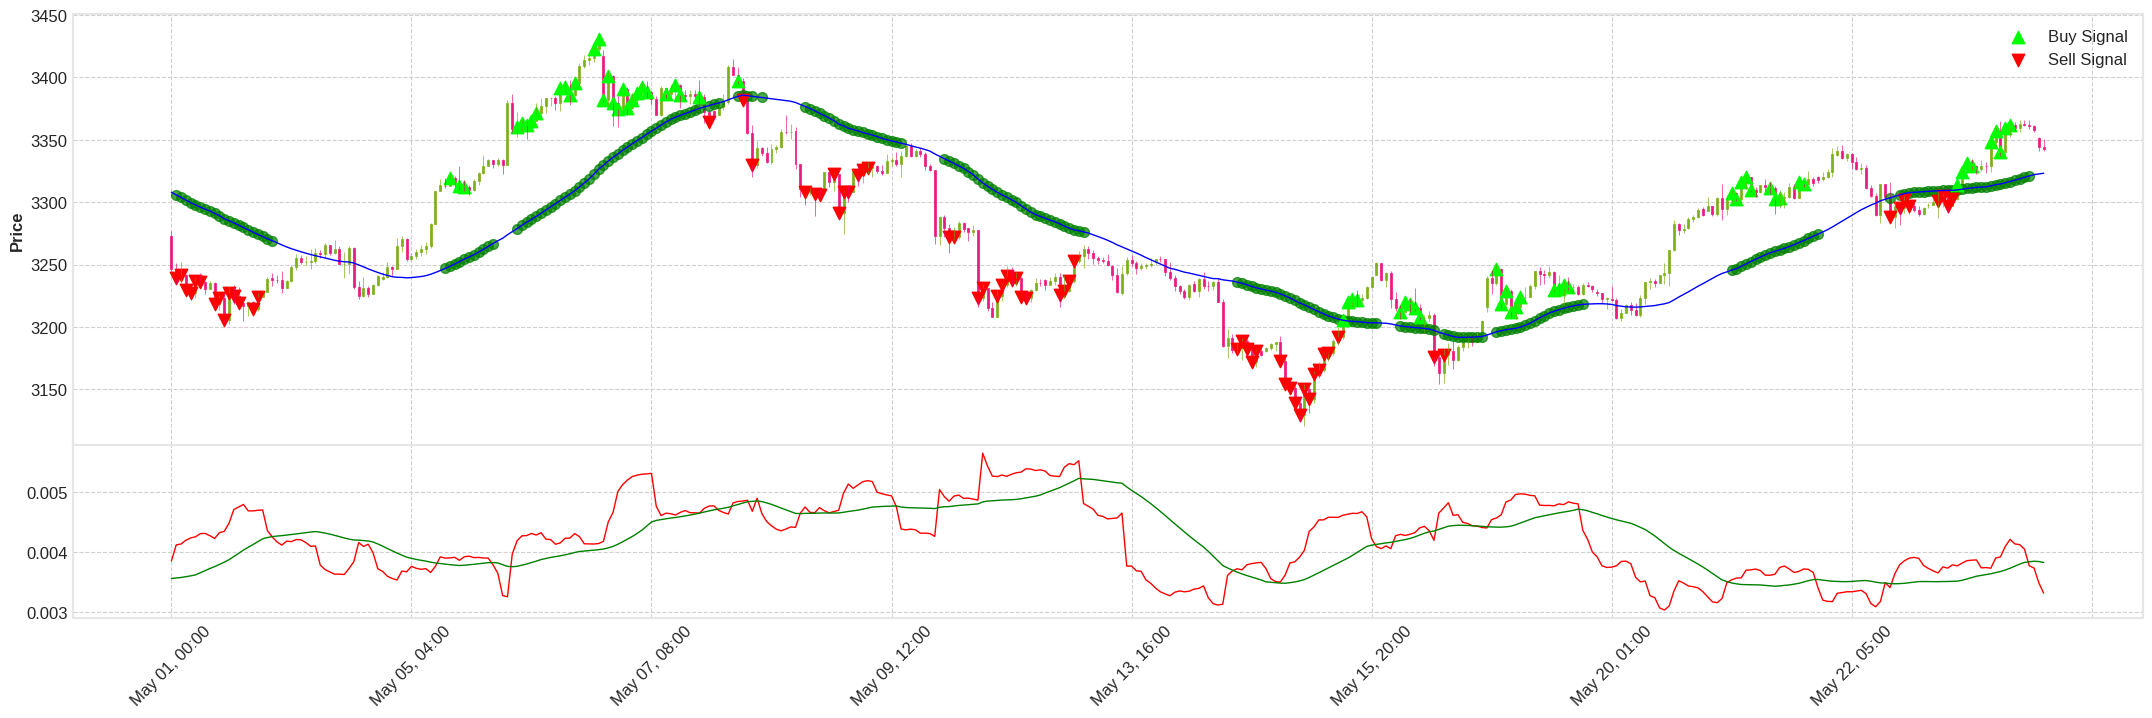

In [173]:
start = '2025-05-01 '
end = '2025-05-25'

dfp = df.loc[start:end]

# Condition: vol shift >= ema_vol
markers_data = pd.Series(np.nan, index=dfp.index)
condition_marker = dfp['vol'].shift(1) >= dfp['ema_vol']
markers_data[condition_marker] = dfp['ema'][condition_marker]

# Derivative condition
derivertive_signal_series = pd.Series(np.nan, index=dfp.index)
condition_derivative = dfp['derivertive_1'] > 1e-8
derivertive_signal_series[condition_derivative] = dfp['Close'][condition_derivative]

# Buy condition
buy_sig = pd.Series(np.nan, index=dfp.index)
buy_con = (
    (dfp['Close'] > dfp['ema']) &
    (dfp['derivertive_1'] > 1e-8) &
    (dfp['vol'].shift(1) > dfp['ema_vol'])
)
buy_sig[buy_con] = dfp['Close'][buy_con]

# 🔻 Sell condition
sell_sig = pd.Series(np.nan, index=dfp.index)
sell_con = (
    (dfp['Close'] < dfp['ema']) &
    (dfp['derivertive_1'] > 1e-8) &
    (dfp['vol'].shift(1) > dfp['ema_vol'])
)
sell_sig[sell_con] = dfp['Close'][sell_con]

# Additional plots
add_plot = [
    mpf.make_addplot(dfp['ema'], color='blue', width=1),
    mpf.make_addplot(markers_data, type='scatter', markersize=50, marker='o', color='g', alpha=0.7),
    #mpf.make_addplot(derivertive_signal_series, type='scatter', markersize=50, marker='o', color='blue', alpha=0.7),
    mpf.make_addplot(dfp['vol'], color='red', width=1, panel=1),
    mpf.make_addplot(dfp['ema_vol'], color='green', width=1, panel=1),
    mpf.make_addplot(buy_sig, type='scatter', markersize=80, marker='^', color='lime', label='Buy Signal'),
    mpf.make_addplot(sell_sig, type='scatter', markersize=80, marker='v', color='red', label='Sell Signal')
]

# Plotting
mpf.plot(
    dfp,
    type='candle',
    style='binance',
    figratio=(30, 9),
    figscale=1.5,
    addplot=add_plot
)

plt.show()

In [174]:
price = df.Close.iloc[-1]
sl = 0.004
tp = 0.008

sl = price *sl
tp = price *tp
print('sl',sl)
print('tp',tp)
sl_ =price-sl
tp_ =price+tp
print('last',price)
print('real ls' ,sl_ )
print('real tp' ,tp_)

sl 13.390559999999999
tp 26.781119999999998
last 3347.64
real ls 3334.24944
real tp 3374.42112


In [175]:
class Momentum(Strategy):
    # Strategy parameters (class-level defaults)
    ema_param = 43
    vol_param = 94
    mu_vol = 30
    sl_pct = 0.010
    tp_pct = 0.012

    def init(self):
        # Use self.data.Close instead of df.Close
        self.close = self.data.Close

        self.ema = self.I(ema, self.close, self.ema_param)
        self.vol = self.I(parkinson_vol, self.data.High, self.data.Low, self.vol_param)
        self.derivertive_1 = self.I(derivertive_1, self.vol)
        self.sma_vol = self.I(sma, self.vol, self.mu_vol)

    def next(self):
        price = self.close[-1]
        sl_amount = price * self.sl_pct
        tp_amount = price * self.tp_pct

        # Get the latest values
        ema_now = self.ema[-1]
        d1_now = self.derivertive_1[-1]
        vol_prev = self.vol[-2]
        sma_vol_now = self.sma_vol[-1]

        buy_con = (
            (price > ema_now) and
            (d1_now > 1e-8) and
            (vol_prev > sma_vol_now)
        )

        sell_con = (
            (price < ema_now) and
            (d1_now > 1e-8) and
            (vol_prev > sma_vol_now)
        )


        if  self.position:
          pass
        elif buy_con:
                self.buy(limit=price,size=1,sl=price - sl_amount, tp=price + tp_amount)
        if self.position:
            pass
        elif sell_con:
             self.sell(limit=price,size=1,sl=price + sl_amount, tp=price- tp_amount)

In [176]:
bt = Backtest(
    df,
    Momentum,
    cash=10000,
    commission=0.00002,
    exclusive_orders=False,
    trade_on_close=True
)
print(bt.run())

Backtest.run:   0%|          | 0/8138 [00:00<?, ?bar/s]

Start                     2024-01-01 23:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 03:00:00
Exposure Time [%]                    30.33164
Equity Final [$]                  10020.17173
Equity Peak [$]                    10113.9509
Commissions [$]                     126.22293
Return [%]                            0.20172
Buy & Hold Return [%]                64.41594
Return (Ann.) [%]                     0.11627
Volatility (Ann.) [%]                 1.76273
CAGR [%]                               0.0996
Sharpe Ratio                          0.06596
Sortino Ratio                          0.0916
Calmar Ratio                          0.05875
Alpha [%]                            -2.60942
Beta                                  0.04364
Max. Drawdown [%]                    -1.97923
Avg. Drawdown [%]                    -0.12104
Max. Drawdown Duration      367 days 16:00:00
Avg. Drawdown Duration       15 days 04:00:00
# Trades                          

In [177]:
bt.plot(plot_trades=True,plot_equity=True,plot_drawdown=True,plot_volume=False,plot_return=False,show_legend=True)

GridPlot(id='p17659', ...)

In [178]:
bt = Backtest(
    df,
    Momentum,
    cash=10000,
    commission=0.00002,
    exclusive_orders=False,
    trade_on_close=True,
)

stats, heatmap = bt.optimize(
    ema_param=range(10, 100, 3),
    vol_param=range(10, 100, 3),
    mu_vol=range(10, 100, 5),
    sl_pct=[0.002, 0.004, 0.006, 0.008, 0.010],
    tp_pct=[0.004, 0.006, 0.008, 0.010, 0.012],
    constraint=lambda p: p.tp_pct > p.sl_pct,
    maximize='Equity Final [$]',
    max_tries=500,
    random_state=42,
    return_heatmap=True
)

Backtest.optimize:   0%|          | 0/313 [00:00<?, ?it/s]

Backtest.run:   0%|          | 0/8156 [00:00<?, ?bar/s]

In [179]:
from backtesting.lib import  plot_heatmaps
plot_heatmaps(heatmap, agg='mean')


GridPlot(id='p18169', ...)

In [181]:
print(stats)

Start                     2024-01-01 23:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 03:00:00
Exposure Time [%]                    28.38296
Equity Final [$]                  10687.98824
Equity Peak [$]                   10702.85824
Commissions [$]                     119.23934
Return [%]                            6.87988
Buy & Hold Return [%]                65.33923
Return (Ann.) [%]                     3.91138
Volatility (Ann.) [%]                 2.68363
CAGR [%]                              3.34144
Sharpe Ratio                           1.4575
Sortino Ratio                         3.78824
Calmar Ratio                          1.76293
Alpha [%]                             4.64142
Beta                                  0.03426
Max. Drawdown [%]                    -2.21868
Avg. Drawdown [%]                    -0.08292
Max. Drawdown Duration      368 days 02:00:00
Avg. Drawdown Duration        6 days 09:00:00
# Trades                          

In [182]:
heatmap.sort_values().iloc[-5:]

,,,,,Equity Final [$]
ema_param,vol_param,mu_vol,sl_pct,tp_pct,
64,82,40,0.008,0.010,10510.024808
40,61,85,0.008,0.010,10526.120930
28,82,25,0.010,0.012,10567.306442
97,67,40,0.008,0.010,10576.393196
31,61,45,0.008,0.010,10687.988239


In [ ]:
multi_data_list

In [184]:
for symbol, data in multi_data.items():
    if data is None:
        print(f"Skipping {symbol} because data is None")
        continue

    bt = Backtest(
        data,
        Momentum,
        cash=10_000,
        commission=0.00002,
        exclusive_orders=True,
        trade_on_close=True,
    )
    stats = bt.run()
    print(f"Backtest results for symbol {symbol}:")
    print(stats)
    #bt.plot() กรณี ต้องการ plot ผลลัพทั้งหมด

Backtest.run:   0%|          | 0/8138 [00:00<?, ?bar/s]

Backtest results for symbol XAUUSD:
Start                     2024-01-01 23:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 03:00:00
Exposure Time [%]                    30.33164
Equity Final [$]                  10100.23477
Equity Peak [$]                    10121.2658
Commissions [$]                     125.68709
Return [%]                            1.00235
Buy & Hold Return [%]                64.42208
Return (Ann.) [%]                     0.57679
Volatility (Ann.) [%]                 1.76498
CAGR [%]                              0.49391
Sharpe Ratio                           0.3268
Sortino Ratio                         0.46806
Calmar Ratio                          0.29142
Alpha [%]                             -1.7878
Beta                                  0.04331
Max. Drawdown [%]                    -1.97923
Avg. Drawdown [%]                    -0.12359
Max. Drawdown Duration      357 days 12:00:00
Avg. Drawdown Duration       14 days 15:00:0

Backtest.run:   0%|          | 0/8570 [00:00<?, ?bar/s]

Backtest results for symbol USDJPY:
Start                     2024-01-01 22:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 04:00:00
Exposure Time [%]                    37.68116
Equity Final [$]                   9991.24692
Equity Peak [$]                   10000.03713
Commissions [$]                       8.51545
Return [%]                           -0.08753
Buy & Hold Return [%]                -0.82308
Return (Ann.) [%]                    -0.05025
Volatility (Ann.) [%]                 0.06699
CAGR [%]                             -0.04325
Sharpe Ratio                         -0.75018
Sortino Ratio                        -1.03011
Calmar Ratio                         -0.39186
Alpha [%]                            -0.09003
Beta                                 -0.00303
Max. Drawdown [%]                    -0.12825
Avg. Drawdown [%]                    -0.12825
Max. Drawdown Duration      502 days 22:00:00
Avg. Drawdown Duration      502 days 22:00:0

Backtest.run:   0%|          | 0/8571 [00:00<?, ?bar/s]

Backtest results for symbol AUDNZD:
Start                     2024-01-01 18:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 08:00:00
Exposure Time [%]                    48.87867
Equity Final [$]                   9999.94767
Equity Peak [$]                   10000.03381
Commissions [$]                       0.03872
Return [%]                           -0.00052
Buy & Hold Return [%]                 0.81118
Return (Ann.) [%]                     -0.0003
Volatility (Ann.) [%]                 0.00031
CAGR [%]                             -0.00026
Sharpe Ratio                         -0.95896
Sortino Ratio                        -1.36686
Calmar Ratio                         -0.25756
Alpha [%]                             -0.0005
Beta                                 -0.00002
Max. Drawdown [%]                    -0.00117
Avg. Drawdown [%]                    -0.00004
Max. Drawdown Duration      354 days 04:00:00
Avg. Drawdown Duration        9 days 06:00:0

Backtest.run:   0%|          | 0/8570 [00:00<?, ?bar/s]

Backtest results for symbol USDCAD:
Start                     2024-01-01 22:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 04:00:00
Exposure Time [%]                    56.61376
Equity Final [$]                  10000.02375
Equity Peak [$]                   10000.03818
Commissions [$]                       0.05447
Return [%]                            0.00024
Buy & Hold Return [%]                 2.59877
Return (Ann.) [%]                     0.00014
Volatility (Ann.) [%]                 0.00046
CAGR [%]                              0.00012
Sharpe Ratio                          0.29652
Sortino Ratio                         0.46758
Calmar Ratio                          0.38533
Alpha [%]                             0.00026
Beta                                 -0.00001
Max. Drawdown [%]                    -0.00035
Avg. Drawdown [%]                    -0.00004
Max. Drawdown Duration      166 days 19:00:00
Avg. Drawdown Duration       10 days 16:00:0

Backtest.run:   0%|          | 0/8570 [00:00<?, ?bar/s]

Backtest results for symbol AUDCAD:
Start                     2024-01-01 22:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 04:00:00
Exposure Time [%]                    46.43432
Equity Final [$]                   9999.93165
Equity Peak [$]                   10000.01452
Commissions [$]                       0.03155
Return [%]                           -0.00068
Buy & Hold Return [%]                -0.39748
Return (Ann.) [%]                    -0.00039
Volatility (Ann.) [%]                 0.00034
CAGR [%]                             -0.00034
Sharpe Ratio                         -1.15171
Sortino Ratio                        -1.51617
Calmar Ratio                         -0.41284
Alpha [%]                            -0.00069
Beta                                     -0.0
Max. Drawdown [%]                    -0.00095
Avg. Drawdown [%]                     -0.0001
Max. Drawdown Duration      443 days 15:00:00
Avg. Drawdown Duration       45 days 08:00:0

Backtest.run:   0%|          | 0/8570 [00:00<?, ?bar/s]

Backtest results for symbol AUDJPY:
Start                     2024-01-01 22:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 04:00:00
Exposure Time [%]                    37.80768
Equity Final [$]                  10003.34169
Equity Peak [$]                   10003.36569
Commissions [$]                       5.39725
Return [%]                            0.03342
Buy & Hold Return [%]                -3.71023
Return (Ann.) [%]                     0.01918
Volatility (Ann.) [%]                   0.061
CAGR [%]                              0.01651
Sharpe Ratio                          0.31444
Sortino Ratio                         0.53592
Calmar Ratio                          0.12669
Alpha [%]                             0.02932
Beta                                  -0.0011
Max. Drawdown [%]                     -0.1514
Avg. Drawdown [%]                    -0.02732
Max. Drawdown Duration      291 days 00:00:00
Avg. Drawdown Duration       62 days 09:00:0

Backtest.run:   0%|          | 0/8570 [00:00<?, ?bar/s]

Backtest results for symbol CADJPY:
Start                     2024-01-01 22:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 04:00:00
Exposure Time [%]                    36.93352
Equity Final [$]                   9996.53387
Equity Peak [$]                   10002.78267
Commissions [$]                       5.61375
Return [%]                           -0.03466
Buy & Hold Return [%]                -3.32862
Return (Ann.) [%]                     -0.0199
Volatility (Ann.) [%]                 0.04939
CAGR [%]                             -0.01712
Sharpe Ratio                         -0.40291
Sortino Ratio                        -0.59955
Calmar Ratio                         -0.27482
Alpha [%]                            -0.04085
Beta                                 -0.00186
Max. Drawdown [%]                     -0.0724
Avg. Drawdown [%]                    -0.00651
Max. Drawdown Duration      293 days 12:00:00
Avg. Drawdown Duration       23 days 23:00:0

Backtest.run:   0%|          | 0/8570 [00:00<?, ?bar/s]

Backtest results for symbol USDTHB:
Start                     2024-01-01 22:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 04:00:00
Exposure Time [%]                    32.45917
Equity Final [$]                   9997.06792
Equity Peak [$]                   10000.16871
Commissions [$]                       1.88599
Return [%]                           -0.02932
Buy & Hold Return [%]                -6.90517
Return (Ann.) [%]                    -0.01683
Volatility (Ann.) [%]                 0.01155
CAGR [%]                             -0.01448
Sharpe Ratio                         -1.45694
Sortino Ratio                        -1.81308
Calmar Ratio                         -0.51589
Alpha [%]                            -0.03331
Beta                                 -0.00058
Max. Drawdown [%]                    -0.03263
Avg. Drawdown [%]                    -0.00557
Max. Drawdown Duration      501 days 18:00:00
Avg. Drawdown Duration       83 days 20:00:0

Backtest.run:   0%|          | 0/8138 [00:00<?, ?bar/s]

Backtest results for symbol XAGUSD:
Start                     2024-01-01 23:00:00
End                       2025-05-26 02:00:00
Duration                    510 days 03:00:00
Exposure Time [%]                     31.2152
Equity Final [$]                  10000.20649
Equity Peak [$]                   10003.58654
Commissions [$]                       1.44618
Return [%]                            0.00206
Buy & Hold Return [%]                 44.4569
Return (Ann.) [%]                     0.00119
Volatility (Ann.) [%]                  0.0437
CAGR [%]                              0.00102
Sharpe Ratio                          0.02725
Sortino Ratio                         0.03625
Calmar Ratio                          0.02222
Alpha [%]                            -0.02892
Beta                                   0.0007
Max. Drawdown [%]                    -0.05358
Avg. Drawdown [%]                    -0.00387
Max. Drawdown Duration      301 days 12:00:00
Avg. Drawdown Duration       13 days 03:00:0